In [1]:
# Some important imports
from transformers import ClapModel, ClapProcessor # CLAP model
import numpy as np # Data manipulation tool
import torch # Neural network development module
import torchaudio.transforms as T # Transforms for audio (spectrogram and everything)
from torchaudio import load # Loader for audio files
from librosa import power_to_db
from sklearn.metrics import pairwise_distances  # Cosine similarity

In [2]:
## change this to your own cache directory to download the models
cache_dir = '/home/a23marmo/Bureau/Projects/Tests en cours/CLAP/cache_models'

device=torch.device("cuda" if torch.cuda.is_available() else "cpu") # Specify the model to make inference
## You can also set this parameter manually (if you have only one GPU, use "cuda:0", or use "cpu" if you don't have a GPU)

In [3]:
# Load the models
cpt1 = "laion/clap-htsat-unfused" # Name of the model
processor_general = ClapProcessor.from_pretrained(cpt1)
model_general = ClapModel.from_pretrained(cpt1,cache_dir=cache_dir).to(device)

# Prints the model
model_general.eval()

/home/a23marmo/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ClapModel(
  (text_model): ClapTextModel(
    (embeddings): ClapTextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ClapTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x ClapTextLayer(
          (attention): ClapTextAttention(
            (self): ClapTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ClapTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

Load and prepare an audio file

In [4]:
## change this to your own audio file
audiofile = 'example.flac'

# Load the audio file
waveform, base_sr = load(audiofile)

# check the sampling rate and resample to 48000 if needed (the models were trained on 48kHz audio)
clap_sr = 48000
if base_sr != clap_sr:
    resampler = T.Resample(base_sr, clap_sr)
    waveform = resampler(waveform)

# check the number of channels and convert to mono if needed
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=False)
else:
    waveform = waveform.squeeze()

# Here we will only process the first 10 seconds of the audio file
waveform = waveform[:(10*clap_sr)]

# play the audio file
from IPython.display import Audio
Audio(waveform, rate=clap_sr)

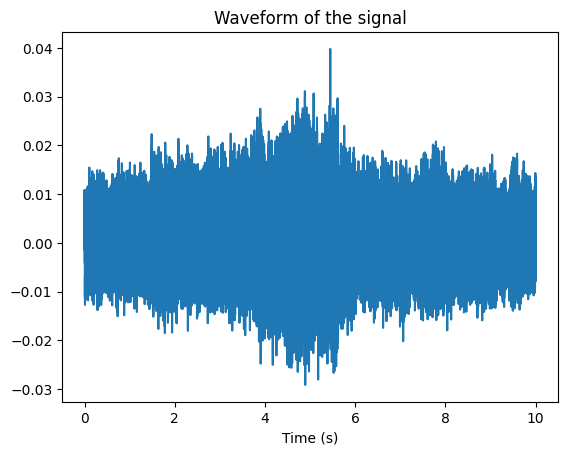

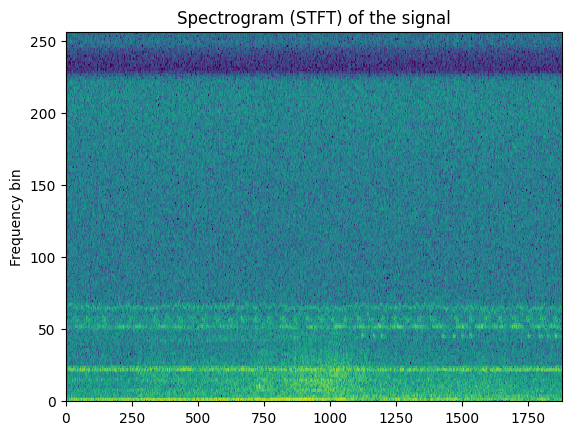

In [5]:
import matplotlib.pyplot as plt # Plotting module
# Plots the waveform
time_axis = torch.arange(0, waveform.shape[0]) / clap_sr
plt.plot(time_axis, waveform)
plt.title("Waveform of the signal")
plt.xlabel("Time (s)")
plt.show()

# Computes and plots the spectrogram
spectrogram = T.Spectrogram(n_fft=512, hop_length = 256)
spec = spectrogram(waveform)
plt.imshow(power_to_db(spec), origin="lower", aspect="auto", interpolation="nearest")
plt.title("Spectrogram (STFT) of the signal")
plt.ylabel("Frequency bin")
plt.show()

In [6]:
## Generate the embeddings

#preprocess the audio
inputs_audio = processor_general(audios=waveform, sampling_rate=clap_sr,return_tensors="pt", padding=True)

# move the inputs to the GPU (inputs audio is a dictionary)        
for key, value in inputs_audio.items():
    inputs_audio[key] = value.to(device)

# run the inputs into the model 
with torch.inference_mode():
    audioembeddings = model_general.get_audio_features(**inputs_audio)

We will try to perform some zero-shot classification on this file. We heard some crickets, a car, maybe a bird. Let's try to classify these three categories in zero-shot by generating text embeddings corresponding to these classes. 

In [7]:
## Here is the list of target "classes" we will use to compute the similarity scores.
## The model will now classify our audio example based on these classes.
# Note that we have added some very unrelated ones to see how the model behaves.

texts = ["Crickets are singing", "A car is passing", "A train is passing",
         "Birds are singing","A dog is barking", 
         "Someone is playing the piano", 
         "Someone is talking"]

Generate the text embeddings

In [8]:
# Process the input texts ("classes")
inputs_text = processor_general(text=texts, return_tensors="pt", padding=True)
for key, value in inputs_text.items():
    inputs_text[key] = value.to(device)

# Classify
with torch.inference_mode():
    outputs_text = model_general.get_text_features(**inputs_text)

Zero-shot classification is performed by searching for the nearest neighbour between the audio embedding and text embeddings

In [9]:
#print("Audio embeddings shape:",audioembeddings.shape) # Embedding of the audio
#print("Text embeddings shape:",outputs_text.shape) # Embedding of the text

# Compute the cosine similarity between the audio embedding and the text embeddings
cosine_similarity = 1-pairwise_distances(audioembeddings.cpu(), outputs_text.cpu(), metric="cosine")

print(f"Most similar text: {texts[np.argmax(cosine_similarity[0,:])]}\n")

# Print the similarity scores
print("In details, with similarity scores:")
for i, text in enumerate(texts):
    print(f"\t{text}: {cosine_similarity[0][i]:.3f}")

Most similar text: Crickets are singing

In details, with similarity scores:
	Crickets are singing: 0.535
	A car is passing: 0.165
	A train is passing: 0.270
	Birds are singing: 0.159
	A dog is barking: -0.001
	Someone is playing the piano: 0.069
	Someone is talking: -0.021


We developed a high level function to classify an audio example, for easeness of use. It is used in the cell below:

In [10]:
import utils
classification = utils.classify_this_audio_file(processor=processor_general, model=model_general, audio=waveform, text_embeddings=utils.esc_50_labels)
print(classification)

Crickets


CLAP needs text labels to perform classification, so we used the ones from ESC-50, a standard dataset. Feel free to use your owns!

What about the ambiguous example presented in the slides?

In [11]:
# Load the audio file
ambiguous_example, base_sr = load("./foley.wav")
ambiguous_example = torch.mean(ambiguous_example, dim=0, keepdim=False)
ambiguous_classification = utils.classify_this_audio_file(processor=processor_general, model=model_general, audio=ambiguous_example, 
                                                          text_embeddings=utils.esc_50_labels)
print(f"From the text labels of ESC-50, the ambiguous sound is classified as: {ambiguous_classification}")

From the text labels of ESC-50, the ambiguous sound is classified as: Crackling fire


From the labels of the ESC-50 dataset, CLAP classified the ambiguous example from the slides as a 'crackling fire', but the correct answer (plastic bag) is not present in the ESC-50 labels. What about classification between the proposed examples in the slides? (plastic bag,people stomping,crackling fire, or rain)

In [12]:
ambiguous_classification = utils.classify_this_audio_file(processor=processor_general, model=model_general, audio=ambiguous_example, 
                                                          text_embeddings=["plastic bag", "people stomping","crackling fire", "rain"])
print(f'Classification between "plastic bag", "people stomping", "crackling fire", and "rain": {ambiguous_classification}')

Classification between "plastic bag", "people stomping", "crackling fire", and "rain": crackling fire


Still failing (but it is a difficult example).

Finally, CLAP can also be used for the classification of multiple audio examples (such as a long dataset). As an example, we calssify 10 examples from the ESC-50 dataset (link to download: https://github.com/karolpiczak/ESC-50/tree/master)

In [22]:
import os 

# Preprocess the dataset
path_to_dataset = "/home/a23marmo/Bureau/10 examples ESC/audio" # The path to the desired dataset (parent folder of audio files)
list_of_audiofiles = os.listdir(path_to_dataset)
duration = 10*clap_sr # 10 seconds
allwaves = []

for curfile in list_of_audiofiles:
    #open the files with torchaudio
    waveform, sr = load(f"{path_to_dataset}/{curfile}")    
    if sr != clap_sr:
        waveform = T.Resample(sr,clap_sr)(waveform)[0,:]

    # append the waveform to the list
    allwaves.append(waveform[:duration])

# concatenate all the waveforms
allwaves = np.stack(allwaves)

print(allwaves.shape)

inputs_audio = processor_general(audios=allwaves, sampling_rate=clap_sr,return_tensors="pt", padding=True)
        
for key, value in inputs_audio.items():
    inputs_audio[key] = value.to(device)

with torch.inference_mode():
    audio_embeddings_dataset = model_general.get_audio_features(**inputs_audio)

(10, 240000)


Now, classify all examples:

In [23]:
text_embeddings=utils.esc_50_labels
inputs_text = processor_general(text=text_embeddings, return_tensors="pt", padding=True)
for key, value in inputs_text.items():
    inputs_text[key] = value.to(device)

# Classify
with torch.inference_mode():
    text_embeddings_clap = model_general.get_text_features(**inputs_text)

cosine_similarity = 1-pairwise_distances(audio_embeddings_dataset.cpu(), text_embeddings_clap.cpu(), metric="cosine")
for i in range(len(list_of_audiofiles)):
    print(f"Embedding for file {i}: {text_embeddings[np.argmax(cosine_similarity[i,:])]}")

Embedding for file 0: Hen
Embedding for file 1: Crackling fire
Embedding for file 2: Glass breaking
Embedding for file 3: Hand saw
Embedding for file 4: Laughing
Embedding for file 5: Keyboard typing
Embedding for file 6: Crackling fire
Embedding for file 7: Helicopter
Embedding for file 8: Hand saw
Embedding for file 9: Door, wood creaks
